# Convolutional Neural Network (CNN) Example

## I/O

In [1]:
TMVA::Tools::Instance();

auto outputFile = TFile::Open("CNN_ClassificationOutput.root", "RECREATE");

TMVA::Factory factory("TMVA_CNN_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" ); 


## Load Data and Features

Input data is an image of 16x16 pixels from an EM shower (photon or electron)

In [2]:
TMVA::DataLoader * loader = new TMVA::DataLoader("dataset");

int imgSize = 8 * 8; 

for(auto i = 0; i < imgSize; i++)
     loader->AddVariable(Form("var%d",i),'F');

## Setup Dataset

In [3]:
TString inputFileName = "data/images_data.root";

auto inputFile = TFile::Open( inputFileName );

TTree *signalTree     = (TTree*)inputFile->Get("sig_tree");
TTree *backgroundTree = (TTree*)inputFile->Get("bkg_tree");

Double_t signalWeight     = 1.0;
Double_t backgroundWeight = 1.0;
   
loader->AddSignalTree    ( signalTree,     signalWeight     );
loader->AddBackgroundTree( backgroundTree, backgroundWeight );

TCut mycuts = ""; 
TCut mycutb = "";

loader->PrepareTrainingAndTestTree( mycuts, mycutb,
                                    "nTrain_Signal=0:nTrain_Background=0:SplitMode=Random:NormMode=NumEvents:!V" );

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


## Boosted Decision Trees (BDT)

In [4]:
//Boosted Decision Trees
factory.BookMethod(loader,TMVA::Types::kBDT, "BDT",
                   "!V:NTrees=800:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" );

Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 5000
                         : Signal     -- testing events             : 5000
                         : Signal     -- training and testing events: 10000
                         : Background -- training events            : 5000
                         : Background -- testing events             : 5000
                         : Background -- training and testing events: 10000
                         : 
DataSetInfo              : Correlation matrix (Signal):
                         : -------------------------------------------------------------------

## Deep Neural Networks (Dense and Convolutional)

In [5]:
bool useDNN = true; 
bool useCNN = true; 
bool useKeras = false; 

### Dense Neural Network (DNN)

In [6]:
if (useDNN) { 
    
     TString inputLayoutString = "InputLayout=1|1|64"; 
     TString batchLayoutString = "BatchLayout=1|128|64";
     TString layoutString ("Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR");
                                                                                                                                                                                       
      //Training strategy
      TString training1("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                        "ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,"
                        "MaxEpochs=20,WeightDecay=1e-4,Regularization=L2,"
                        "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.");
  
      TString trainingStrategyString ("TrainingStrategy=");
      trainingStrategyString += training1; // + "|" + training2 + "|" + training3;

      //Options                                                                                                                                                                
      TString dnnOptions("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                          "WeightInitialization=XAVIERUNIFORM");
      dnnOptions.Append (":"); dnnOptions.Append (inputLayoutString);
      dnnOptions.Append (":"); dnnOptions.Append (batchLayoutString);
      dnnOptions.Append (":"); dnnOptions.Append (layoutString);
      dnnOptions.Append (":"); dnnOptions.Append (trainingStrategyString);

      dnnOptions += ":Architecture=Standard";
      factory.BookMethod(loader, TMVA::Types::kDL, "DL_DENSE", dnnOptions);
}

Factory                  : Booking method: DL_DENSE
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIERUNIFORM:InputLayout=1|1|64:BatchLayout=1|128|64:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=L2,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.:Architecture=Standard"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightIn

### Convolutional Neural Networks (CNN)

In [7]:
if (useCNN) { 
    
    TString inputLayoutString("InputLayout=1|8|8");                                                                                                                                     
    TString batchLayoutString("BatchLayout=128|1|64");
    TString layoutString     ("Layout=CONV|10|3|3|1|1|1|1|RELU,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,"
                              "RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|LINEAR");

    //Training strategy                                                                                                                          
    TString training1("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                     "ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,"
                     "MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"
                     "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0");
    TString trainingStrategyString ("TrainingStrategy=");
    trainingStrategyString += training1; // + "|" + training1 + "|" + training2;   }
    
    //Options                                                                                                                         
    TString cnnOptions ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                       "WeightInitialization=XAVIERUNIFORM");

    cnnOptions.Append(":"); cnnOptions.Append(inputLayoutString);
    cnnOptions.Append(":"); cnnOptions.Append(batchLayoutString);
    cnnOptions.Append(":"); cnnOptions.Append(layoutString);
    cnnOptions.Append(":"); cnnOptions.Append(trainingStrategyString);
    cnnOptions.Append(":Architecture=CPU");

    factory.BookMethod(loader, TMVA::Types::kDL, "DL_CNN", cnnOptions);
}

Factory                  : Booking method: DL_CNN
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIERUNIFORM:InputLayout=1|8|8:BatchLayout=128|1|64:Layout=CONV|10|3|3|1|1|1|1|RELU,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSEN

## Train Methods

In [8]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var0' <---> Output : variable 'var0'
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
                         : Input : variable 'var5' <---> Output : variable 'var5'
                         : Input : variable 'var6' <---> Output : variable 'var6'
                         : Input : variable 'var7' <---> Output : variable 'var7'
                         : Input : variable 'var8' <---> Output : variable 'var8'
                         : In

                         : Ranking input variables (method unspecific)...
IdTransformation         : Ranking result (top variable is best ranked)
                         : ------------------------------
                         : Rank : Variable  : Separation
                         : ------------------------------
                         :    1 : var31     : 1.987e-02
                         :    2 : var60     : 1.452e-02
                         :    3 : var39     : 1.448e-02
                         :    4 : var38     : 1.352e-02
                         :    5 : var11     : 1.318e-02
                         :    6 : var4      : 1.276e-02
                         :    7 : var24     : 1.248e-02
                         :    8 : var23     : 1.231e-02
                         :    9 : var59     : 1.229e-02
                         :   10 : var30     : 1.203e-02
                         :   11 : var51     : 1.037e-02
                         :   12 : var3      : 9.927e-03
         

                         :         14 |     0.510986    0.612368     1.33941    0.634266     14158.8           2
                         :         15 |     0.505149    0.611125     1.34217     0.63972       14213           3
                         :         16 |     0.502665    0.612384     1.34502    0.635261     14066.7           4
                         :         17 |     0.500445    0.612558     1.33804    0.634882     14198.8           5
                         :         18 |     0.497931    0.614111     1.33854    0.635625     14203.8           6
                         :         19 |      0.49522    0.615309     1.33899    0.634642     14174.9           7
                         :         20 |     0.493066     0.61573     1.34453    0.638331     14137.7           8
                         : 
                         : Elapsed time for training with 10000 events: 27.8 sec         
                         : Evaluate deep neural network on the STANDARD architecture  using

                         : Reading weight file: dataset/weights/TMVA_CNN_Classification_DL_DENSE.weights.xml
                         : Reading weight file: dataset/weights/TMVA_CNN_Classification_DL_CNN.weights.xml


## Test and Evaluate Algorithms

In [9]:
factory.TestAllMethods();

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.513 sec       
Factory                  : Test method: DL_DENSE for Classification performance
                         : 
                         : Evaluate deep neural network on the STANDARD architecture  using batches with size = 1000
                         : 
DL_DENSE                 : [dataset] : Evaluation of DL_DENSE on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.332 sec       
Factory                  : Test method: DL_CNN for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
DL_CNN   

In [10]:
factory.EvaluateAllMethods();    

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_BDT            : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var0:     2.4375     3.8557   [    -9.9918     19.977 ]
                         :     var1:     3.9666     4.4410   [    -9.7103     25.867 ]
                         :     var2:     5.4753     4.8697   [    -8.5006     29.836 ]
                         :     var3:     6.4672     5.0291   [    -7.9837     27.817 ]
                         :     var4:     6.5185     5.0298   [    -10.282     27.355 ]
                         :     var5:     5.4855     4.8555   [    -7.9858     27.156 ]
                         :     var6:   

Factory                  : Evaluate classifier: DL_CNN
                         : 
DL_CNN                   : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TFHandler_DL_CNN         : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var0:     2.4375     3.8557   [    -9.9918     19.977 ]
                         :     var1:     3.9666     4.4410   [    -9.7103     25.867 ]
                         :     var2:     5.4753     4.8697   [    -8.5006     29.836 ]
                         :     var3:     6.4672     5.0291   [    -7.9837     27.817 ]
                         :     var4:     6.5185     5.0298   [    -10.282     27.355 ]
                         :     var5:     5.4855  

Dataset:dataset          : Created tree 'TestTree' with 10000 events
                         : 
Dataset:dataset          : Created tree 'TrainTree' with 10000 events
                         : 
Factory                  : Thank you for using TMVA!
                         : For citation information, please visit: http://tmva.sf.net/citeTMVA.html


## Plot ROC Curve

In [11]:
//%jsroot on

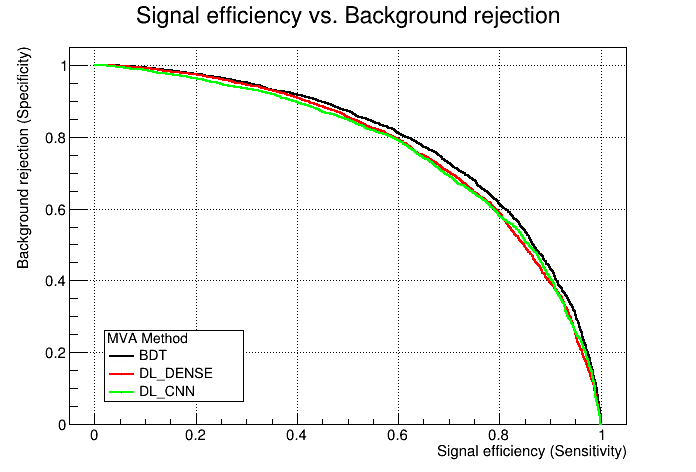

In [12]:
c1 = factory.GetROCCurve(loader);
c1->Draw();


In [13]:
outputFile->Close();